<a href="https://colab.research.google.com/github/granja17/FootballPredict/blob/main/Projeto_IACH_parte_final_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando bibliotecas

In [1]:
import os
import datetime
import tensorflow as tf
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
nome_do_arquivo = '/content/Big 5 2010 - 2020 - att.csv'

df = pd.read_csv(nome_do_arquivo, sep=';')
filtro = (df['Movement'] == 'in')
df = df.loc[filtro]

pd.to_numeric(df.Fee)
pd.to_numeric(df.Age)
df['Is Loan'] = df['Is Loan'].astype(str)
df['Age'] = df['Age'].astype(int)
df['Fee'].fillna(0, inplace=True)
df['Fee'] = df['Fee'].astype(int)
df['Season'] = pd.to_datetime(df['Season'], format='%Y')
df['Season'] = df['Season'].dt.strftime('%Y')
df.rename(columns={'Market Value ': 'Market Value'}, inplace=True)
df.info('Age')
df.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11945 entries, 0 to 36539
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Club             11945 non-null  object
 1   Player           11945 non-null  object
 2   Age              11945 non-null  int64 
 3   Nationality      11945 non-null  object
 4   Position         11945 non-null  object
 5   Short Position   11945 non-null  object
 6   Market Value     11945 non-null  int64 
 7   Dealing Club     11945 non-null  object
 8   Dealing Country  11689 non-null  object
 9   Fee              11945 non-null  int64 
 10  Movement         11945 non-null  object
 11  Window           11945 non-null  object
 12  League           11945 non-null  object
 13  Season           11945 non-null  object
 14  Is Loan          11945 non-null  object
 15  Loan Status      296 non-null    object
dtypes: int64(3), object(13)
memory usage: 1.5+ MB


,Club,Player,Age,Nationality,Position,Short Position,Market Value,Dealing Club,Dealing Country,Fee,Movement,Window,League,Season,Is Loan,Loan Status
0,Paris Saint-Germain,Neymar,25,Brazil,Left Winger,Attacker,100000000,FC Barcelona,Spain,222000000,in,summer,Ligue 1,2017,False,NaN
3,Paris Saint-Germain,Kylian Mbappé,19,France,Centre-Forward,Attacker,120000000,Monaco,France,180000000,in,summer,Ligue 1,2018,False,NaN
5,FC Barcelona,Philippe Coutinho,25,Brazil,Attacking Midfield,Midfielder,90000000,Liverpool,England,135000000,in,winter,Laliga,2017,False,NaN
6,FC Barcelona,Ousmane Dembélé,20,France,Right Winger,Attacker,33000000,Bor. Dortmund,Germany,135000000,in,summer,Laliga,2017,False,NaN
8,Atlético Madrid,João Félix,19,Portugal,Second Striker,Attacker,70000000,Benfica,Portugal,127200000,in,summer,Laliga,2019,False,NaN


In [3]:
df.set_index('Season', drop=True, inplace=True)
df.head()


,Club,Player,Age,Nationality,Position,Short Position,Market Value,Dealing Club,Dealing Country,Fee,Movement,Window,League,Is Loan,Loan Status
Season,,,,,,,,,,,,,,,
2017,Paris Saint-Germain,Neymar,25,Brazil,Left Winger,Attacker,100000000,FC Barcelona,Spain,222000000,in,summer,Ligue 1,False,NaN
2018,Paris Saint-Germain,Kylian Mbappé,19,France,Centre-Forward,Attacker,120000000,Monaco,France,180000000,in,summer,Ligue 1,False,NaN
2017,FC Barcelona,Philippe Coutinho,25,Brazil,Attacking Midfield,Midfielder,90000000,Liverpool,England,135000000,in,winter,Laliga,False,NaN
2017,FC Barcelona,Ousmane Dembélé,20,France,Right Winger,Attacker,33000000,Bor. Dortmund,Germany,135000000,in,summer,Laliga,False,NaN
2019,Atlético Madrid,João Félix,19,Portugal,Second Striker,Attacker,70000000,Benfica,Portugal,127200000,in,summer,Laliga,False,NaN


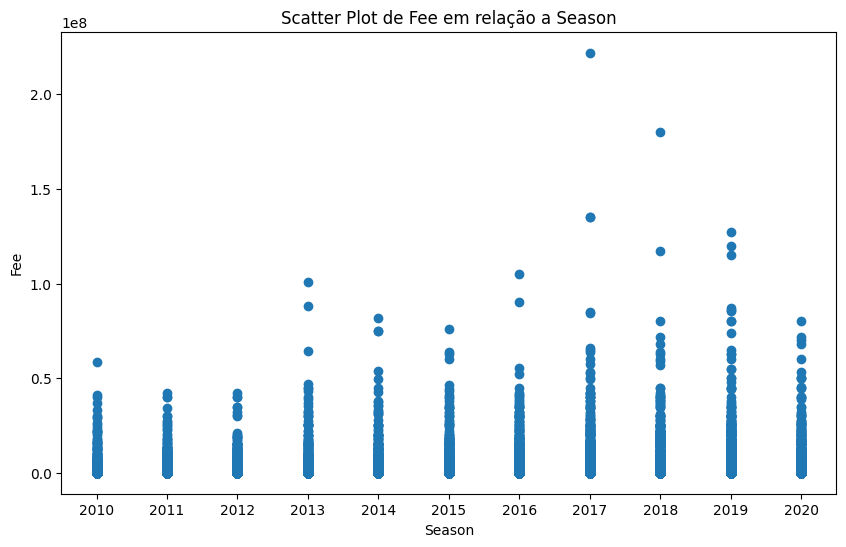

In [4]:
# Ordenação por 'Season'
df = df.sort_values(by='Season')

#scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['Fee'])
plt.xlabel('Season')
plt.ylabel('Fee')
plt.title('Scatter Plot de Fee em relação a Season')
plt.show()


# Definindo Labels

In [5]:
condicoes = [
    (df['Fee'] > 60000000),
    (df['Fee'] >= 50000000) & (df['Fee'] <= 60000000),
    (df['Fee'] >= 40000000) & (df['Fee'] < 50000000),
    (df['Fee'] >= 30000000) & (df['Fee'] < 40000000),
    (df['Fee'] >= 20000000) & (df['Fee'] < 30000000),
    (df['Fee'] >= 10000000) & (df['Fee'] < 20000000),
    (df['Fee'] > 5000000) & (df['Fee'] < 10000000),
    (df['Fee'] > 0) & (df['Fee'] < 5000000),
    (df['Fee'] == 0)
]

valores = ['A++', 'A+', 'A', 'B+', 'B', 'C+', 'C', 'C-', 'D']

df['Classificacao'] = np.select(condicoes, valores, default='D')

df = df.sort_values(by='Fee', ascending=False)


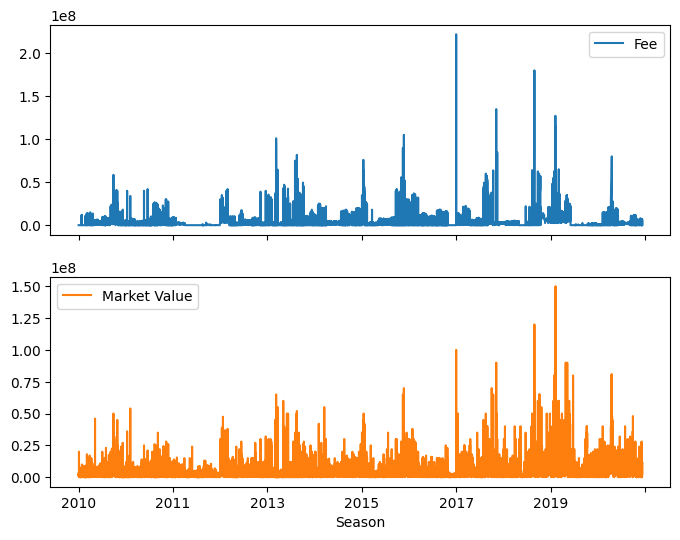

In [6]:
df = df.sort_values(by = 'Season', ascending = True)
plot_cols = ['Fee', 'Market Value']
plot_features = df[plot_cols]
plot_features.index = df.index
_ = plot_features.plot(subplots=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11945 entries, 2010 to 2020
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Club             11945 non-null  object
 1   Player           11945 non-null  object
 2   Age              11945 non-null  int64 
 3   Nationality      11945 non-null  object
 4   Position         11945 non-null  object
 5   Short Position   11945 non-null  object
 6   Market Value     11945 non-null  int64 
 7   Dealing Club     11945 non-null  object
 8   Dealing Country  11689 non-null  object
 9   Fee              11945 non-null  int64 
 10  Movement         11945 non-null  object
 11  Window           11945 non-null  object
 12  League           11945 non-null  object
 13  Is Loan          11945 non-null  object
 14  Loan Status      296 non-null    object
 15  Classificacao    11945 non-null  object
dtypes: int64(3), object(13)
memory usage: 1.5+ MB


In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,11945.0,2.467953e+01,4.132550e+00,15.0,21.0,24.0,27.0,42.0
Market Value,11945.0,4.626303e+06,7.644412e+06,0.0,800000.0,2000000.0,5000000.0,150000000.0
Fee,11945.0,3.378881e+06,8.566973e+06,0.0,0.0,300000.0,3000000.0,222000000.0


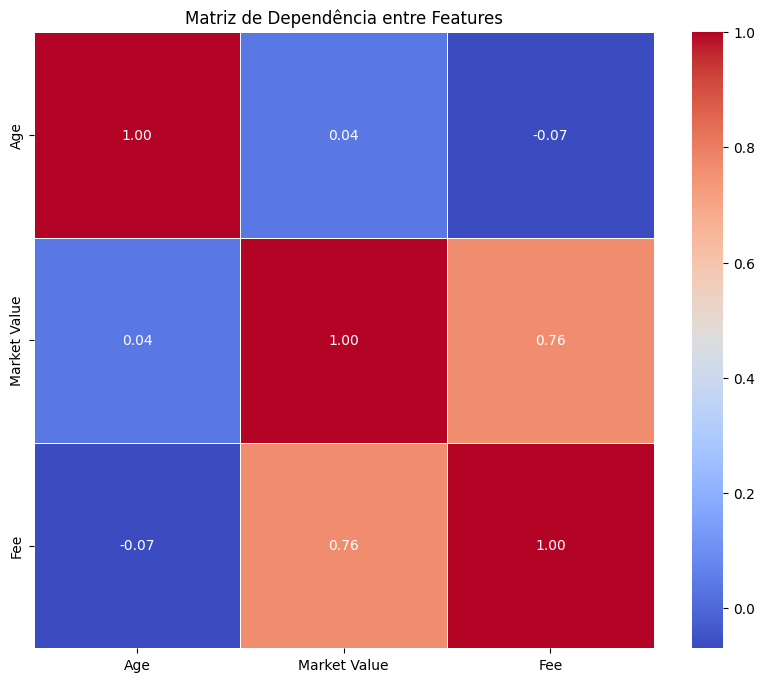

In [9]:
numeric_cols = df.select_dtypes(include=['int64']).columns
numeric_data = df[numeric_cols]

# matriz de correlação
correlation_matrix = numeric_data.corr()

# mapa de calor para visualizar a matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Matriz de Dependência entre Features')
plt.show()


In [10]:
pip install scikit-learn


In [11]:
df.index = df.index.astype(int)

# treino (2010 a 2019) e teste (2020)
train_data = df[df.index < 2020]
test_data = df[df.index == 2020]

# features (X) e label (y)
X_train = train_data.drop("Classificacao", axis=1)
y_train = train_data["Classificacao"]

X_test = test_data.drop("Classificacao", axis=1)
y_test = test_data["Classificacao"]

# valores nulos
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

X_train, X_test = X_train.align(X_test, join='outer', axis=1, fill_value=0)

# modelo de Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# previsões no conjunto de teste
predictions = model.predict(X_test)

# desempenho do modelo
accuracy = accuracy_score(y_test, predictions)
print(f"Acurácia do modelo: {accuracy}")

# o relatório de classificação
print(classification_report(y_test, predictions))


Acurácia do modelo: 0.8329383886255924
              precision    recall  f1-score   support

           A       0.00      0.00      0.00         6
          A+       0.00      0.00      0.00         5
         A++       0.00      0.00      0.00         4
           B       0.53      0.36      0.43        28
          B+       1.00      0.22      0.36         9
           C       0.62      0.16      0.26        62
          C+       0.54      0.42      0.47        67
          C-       0.72      1.00      0.84       259
           D       1.00      0.98      0.99       404

    accuracy                           0.83       844
   macro avg       0.49      0.35      0.37       844
weighted avg       0.82      0.83      0.80       844



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


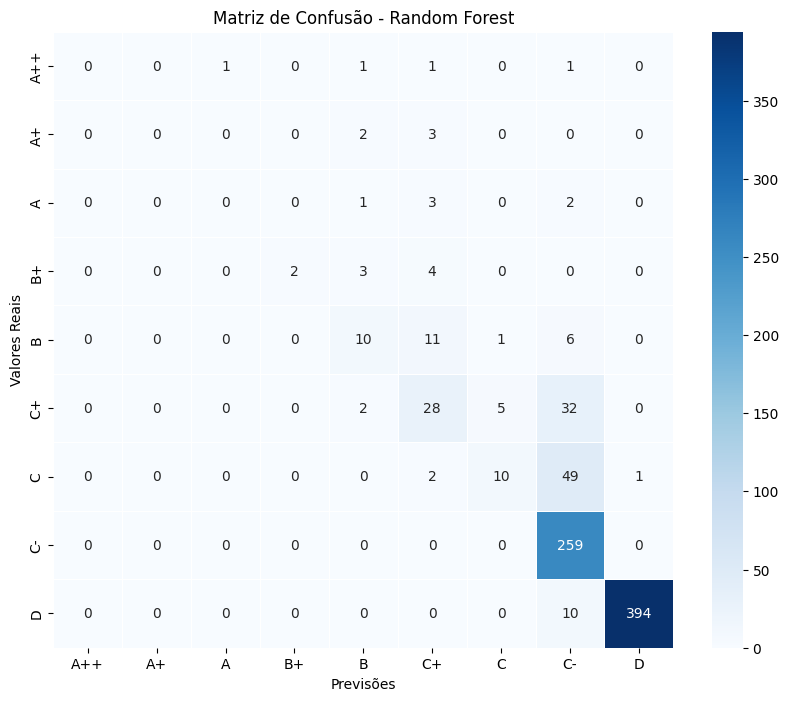

In [12]:
# Matriz de confusão
conf_matrix = confusion_matrix(y_test, predictions, labels=['A++', 'A+', 'A', 'B+', 'B', 'C+', 'C', 'C-', 'D'])


conf_matrix_df = pd.DataFrame(conf_matrix, index=['A++', 'A+', 'A', 'B+', 'B', 'C+', 'C', 'C-', 'D'], columns=['A++', 'A+', 'A', 'B+', 'B', 'C+', 'C', 'C-', 'D'])

# heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues", linewidths=.5)
plt.xlabel('Previsões')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão - Random Forest')
plt.show()
